In [1]:
#!pip install pytube
#!pip install plotly
!pip install face_recognition
#!pip install CMake

In [2]:
import os           

# Check if string is appropriate youtube link
import re
import cv2
import numpy as np
import pandas as pd
#from facenet_pytorch import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from pytube import YouTube

import face_recognition

import seaborn as sns
import plotly.express as px

# DEBUG-Mode stops operations when max_emotions were detected and also prints a short summary
DEBUG = True
if DEBUG:
    import time
    debug_params = {
        'max_emotions' : 100
    }

In [17]:
def get_path(kind):
    if kind == "youtube":
        return "https://www.youtube.com/watch?v=vtT78TfDfXU"                  # Random video
        #return = 'https://www.youtube.com/watch?v=embYkODkzcs'                 # 7 basic emotions
    if kind == "local":
        # adjust individually
        return '/Users/steve/Neue_Fische/face_demo/vids/Video_One_output.mp4'
    if kind == "error_on_purpose":
        return "wrongful path"
    else:
        raise ValueError(f"Passed Argument kind must bei in ['youtube', 'local', 'error_on_purpose'] but was: {kind}")

def youtube_stream(yt_link):
    # Load the video from YouTube
    yt_video = YouTube(yt_link)
    stream = yt_video.streams.get_highest_resolution()  # get the highest resolution stream
    print("Title:", yt_video.title)
    print("Length:", yt_video.length, "seconds")
    print("Available video quality options:")
    resolutions = set()  # use a set to keep track of unique resolutions
    for s in yt_video.streams.filter(type="video"):
        if s.resolution not in resolutions:
            print(s.resolution)
            resolutions.add(s.resolution)
    stream.download()
    return cv2.VideoCapture(stream.default_filename)

def local_stream(local_path):
    return cv2.VideoCapture(local_path)

def get_stream(path):
    # Check if the string is a YouTube link
    if re.match(r'(https?://)?(www\.)?(youtube\.com|youtu\.?be)/.+$', path):
        return youtube_stream(path)
    # Check if the string is a local path
    elif os.path.isfile(path):
        return local_stream(path)
    # Check if the path is a local file path but no file is found
    elif os.path.exists(path):
        raise ValueError(f"File not found at path: {path}")
    # If it's neither a local path nor a YouTube link, raise an error
    else:
        raise ValueError("The input string is neither a local path nor a YouTube link.")
    
def load_emotion_classifier():
    return load_model("../models/emotion_model.hdf5", compile=False)

def preprocess_face(face, input_face_size):
    face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)  # Convert the face to grayscale
    face = cv2.resize(face, (input_face_size[1], input_face_size[0]))  # Swap width and height
    face = face.astype('float32') / 255.0
    face = np.expand_dims(face, axis=-1)  # Add an additional dimension for grayscale channel
    face = np.expand_dims(face, axis=0)
    return face

def print_debug_report(operating_results):    
    print(f'{operating_results["analyzed_emotions"]} faces found in {operating_results["analyzed_frames"]} frames.')
    print(f'{operating_results["frames_without_faces"]} frames had no face detected ({operating_results["frames_without_faces_ratio"]}%).')
    print(f'Stopped operations after around {operating_results["processed_video_time"]} seconds into the video.')
    print(f'Execution time: {operating_results["runtime"]} seconds, processing (roughly) {round(operating_results["processed_video_time"]/operating_results["runtime"],2)} seconds of video per second of execution')

    
def get_ordered_emotions():
    return ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def get_overview_df(emotions, frame_info, frame_info_cols):
    assert len(frame_info[0]) == len(frame_info_cols), \
        f"Number of columns in frame_info and number of passed names in frame_info_cols is not the same: {len(frame_info[0])} != {len(frame_info_cols)}."

    df_emotions = pd.DataFrame(emotions, columns=get_ordered_emotions())
    df_frame_info = pd.DataFrame(frame_info, columns=frame_info_cols)
    df_all_info = pd.concat([df_emotions, df_frame_info], axis=1)
    return df_all_info

def get_plottable_df(emotions, frame_info, frame_info_cols):

    assert len(frame_info[0]) == len(frame_info_cols), \
        f"Number of columns in frame_info and number of passed names in frame_info_cols is not the same: {len(frame_info[0])} != {len(frame_info_cols)}."

    df_emotions = pd.DataFrame(emotions, columns=get_ordered_emotions())
    df_frame_info = pd.DataFrame(frame_info, columns=frame_info_cols)
    df_all_info = pd.concat([df_emotions, df_frame_info], axis=1)
    df_plotting = pd.melt(df_all_info, id_vars=frame_info_cols, value_vars=get_ordered_emotions(), var_name='emotion', value_name='probability')
    return df_plotting

In [18]:
if DEBUG: start_time = time.time()

# Define video path
path = get_path('youtube')

# Set the number of frames to skip
frames_to_skip = 1

# Get Video as cv2.VideoCapture
# Can access Youtube Video or local file
video = get_stream(path)

# Initialize the face detection model
#face_detector = face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize the emotion detection model
emotion_classifier = load_emotion_classifier()

# Initialize lists to store emotions and frame_info
emotions = []
frame_info = []

# Initialize counters
frames_without_faces_counter = 0
individual_id_counter = 0
face_embeddings = {}

# Loop through each frame of the video
while True:

    # Read the next frame from the video
    ret, frame = video.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Increment the frame counter
    current_frame_nr = int(video.get(cv2.CAP_PROP_POS_FRAMES))

    # Skip frames based on the frames_to_skip parameter
    if current_frame_nr % frames_to_skip != 0:
        continue
    
    # Convert the frame from BGR to RGB color space
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect faces in the frame and return array of bounding boxes
    face_locations = face_recognition.face_locations(rgb_frame)

    # Check if any faces were found
    if not face_locations:
        frames_without_faces_counter += 1
        continue
    
    for i, face_location in enumerate(face_locations):
        top, right, bottom, left = face_location
        face_landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
        x, y, w, h = left, top, right - left, bottom - top
        face = rgb_frame[top:bottom, left:right]
        face = preprocess_face(face, input_face_size=emotion_classifier.input_shape[1:3])
        prob = emotion_classifier.predict(face)[0]

        emotions.append(prob)

    for i, face_landmark in enumerate(face_landmarks):
        if not face_landmark:
            continue

        if i < len(face_locations):
            face_encoding = face_recognition.face_encodings(rgb_frame, [face_locations[i]])[0]
        else:
            continue            
        current_individual_ids = []

        # Compare the current face encoding with the existing face embeddings
        for individual_id, individual_face_encoding in face_embeddings.items():
            if face_recognition.compare_faces([individual_face_encoding], face_encoding)[0]:
                current_individual_ids.append(individual_id)
                break
        else:
            individual_id_counter += 1
            current_individual_ids.append(individual_id_counter)
            face_embeddings[individual_id_counter] = face_encoding
            
        # Add the current timestamp (milliseconds) and probabilities of emotions to the frame_description list
        # current implementation to prepare for tuple-wise operation, change frame later to character_nr
        
        frame_info.append(
            (round(video.get(cv2.CAP_PROP_POS_MSEC) / 1000, 2),
             current_frame_nr,
             current_individual_ids[-1]
             )
        )    

    if DEBUG:
        # For debugging reasons, we stop when we have 1000 emotion values
        if len(emotions) > debug_params['max_emotions']:
            break

# Release the video and close the window
video.release()

if DEBUG: end_time = time.time()

if DEBUG:
    # When in DEBUG-mode, print some statistics about the faces and emotions detected
    operating_results = {'analyzed_emotions': len(emotions),
                         'analyzed_frames':frame_info[-1][1], 
                         'frames_without_faces':frames_without_faces_counter,
                         'frames_without_faces_ratio': round(100*frames_without_faces_counter/frame_info[-1][1],2),
                         'processed_video_time': round(frame_info[-1][0] / 1000 ,2),
                         'runtime': round(end_time - start_time,2)}
    
    print_debug_report(operating_results)
    
df_plotting = get_plottable_df(emotions, frame_info, frame_info_cols=['pos_sec', 'frame', 'character_id'])

Title: The Easiest Monologue in the World! All Emotions in 1 Minute!
Length: 74 seconds
Available video quality options:
144p
360p
720p
2160p
1440p
1080p
480p
240p
1/1 [==============================] - 0s 301ms/step


2023-03-21 09:04:28.529690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step
101 faces found in 101 frames.
0 frames had no face detected (0.0%).
Stopped operations after around 0.0 seconds into the video.
Execution time: 36.89 seconds, processing (roughly) 0.0 seconds of video per second of execution


In [5]:
face_locations

[(99, 812, 420, 491)]

In [6]:
face_landmarks

{'chin': [(502, 214),
  (506, 254),
  (511, 293),
  (523, 331),
  (542, 364),
  (570, 392),
  (602, 414),
  (639, 430),
  (680, 432),
  (721, 424),
  (753, 402),
  (780, 371),
  (799, 337),
  (811, 300),
  (816, 264),
  (817, 229),
  (818, 193)],
 'left_eyebrow': [(536, 160), (555, 139), (584, 129), (614, 129), (641, 136)],
 'right_eyebrow': [(689, 133), (714, 125), (740, 125), (764, 134), (781, 150)],
 'nose_bridge': [(668, 156), (669, 172), (672, 188), (673, 206)],
 'nose_tip': [(638, 240), (655, 243), (671, 246), (686, 243), (698, 239)],
 'left_eye': [(567, 177),
  (586, 171),
  (603, 169),
  (621, 174),
  (604, 175),
  (586, 176)],
 'right_eye': [(704, 171),
  (723, 164),
  (739, 165),
  (757, 171),
  (739, 171),
  (722, 170)],
 'top_lip': [(596, 300),
  (621, 277),
  (651, 268),
  (670, 271),
  (690, 267),
  (719, 276),
  (745, 295),
  (736, 295),
  (691, 279),
  (671, 281),
  (651, 280),
  (606, 300)],
 'bottom_lip': [(745, 295),
  (723, 327),
  (696, 341),
  (674, 343),
  (653, 

In [7]:
df_overview  = get_overview_df(emotions, frame_info, frame_info_cols=['pos_sec', 'frame', 'character_id'])

In [8]:
df_overview.head(50)

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral,pos_sec,frame,character_id
0,0.001277,3.640794e-06,0.001933,0.992097,0.000532,0.000181,0.003977,0.00,1,1
1,0.002029,9.641964e-06,0.003238,0.987087,0.001022,0.000262,0.006353,0.04,2,1
2,0.001432,6.224954e-06,0.002256,0.986627,0.000571,0.000267,0.008840,0.08,3,1
3,0.001430,2.079919e-06,0.002129,0.985649,0.000392,0.000416,0.009982,0.12,4,1
4,0.002704,2.856537e-06,0.007057,0.975418,0.000999,0.000775,0.013044,0.17,5,1
5,0.003063,7.155649e-06,0.005064,0.983866,0.001301,0.000365,0.006335,0.21,6,1
6,0.005908,2.100967e-05,0.008338,0.965988,0.002928,0.000593,0.016225,0.25,7,1
7,0.001580,1.046303e-06,0.002771,0.988864,0.000559,0.000753,0.005472,0.29,8,1
8,0.002516,1.412707e-06,0.008207,0.965961,0.000750,0.003231,0.019334,0.33,9,1
9,0.002385,2.077597e-06,0.012756,0.972430,0.001205,0.001052,0.010171,0.38,10,1


In [9]:
df_plotting.head(100)

,pos_sec,frame,character_id,emotion,probability
0,0.00,1,1,Angry,0.001277
1,0.04,2,1,Angry,0.002029
2,0.08,3,1,Angry,0.001432
3,0.12,4,1,Angry,0.001430
4,0.17,5,1,Angry,0.002704
...,...,...,...,...,...
95,3.96,96,1,Angry,0.120509
96,4.00,97,1,Angry,0.191557
97,4.04,98,1,Angry,0.153173
98,4.08,99,1,Angry,0.322967


In [10]:
#df_10th = df_plotting[df_plotting["frame"] % 3 == 0]  # select every 10th frame

fig = px.bar(df_plotting, x="pos_sec", y='probability', color = 'emotion',
             barmode="stack", title="Distribution of Emotions across Frames (every 10th frame)")
fig.update_layout(xaxis_title="Frame", yaxis_title="Emotion Distribution",     title={
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })
fig.show()

In [11]:
#df_10th = df_emotions[df_emotions["Frame"] % 20 == 0]  # select every 10th frame

# assuming your DataFrame is named df
fig = px.area(df_plotting, x="pos_sec", y='probability', color = 'emotion',
              color_discrete_sequence=px.colors.sequential.Viridis, title="Emotion-Map")

fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    yaxis=dict(
        title='Emotion distribution'
    ),
    xaxis=dict(
        title='Frame'
    ),
    title={
        'y': 0.97,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

<Axes: xlabel='pos_sec', ylabel='probability'>

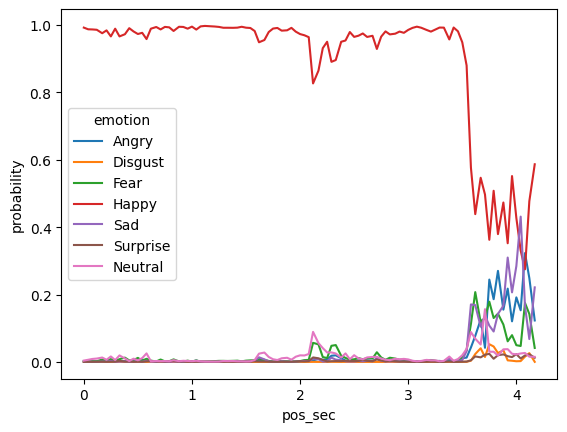

In [12]:
sns.lineplot(data = df_plotting, x = 'pos_sec', y='probability', hue = 'emotion')

In [13]:
fig = px.area(df_plotting, x="pos_sec", y="probability", color="emotion")
fig.show()

In [14]:
df = df_plotting
df['moving_avg'] = df['probability'].rolling(window=10, center=True).mean()

In [15]:
fig = px.area(df, x="pos_sec", y="moving_avg", color="emotion")
fig.show()

# I Adjusted plots until here

### Still Open
* Periods with no people are by now interlinked - so we have straight in the original data and valleys forming in the rolling mean.
* Tha Barcharts show quite well when multiple people com into play - but by now, their values are summed up. If we can get Character Recognition to work, that will be great - if not, at least we can try to reduce it down to one person per frame, but there's no guarantee that we always get the same person.
* With objects and classes we could structure the code even better
* I have the feeling from my videos that the performance is not super good right - maybe we achieve to get better results somehow.
* Much faster on youtube video data looking at Video_seconds analyzed per processing second.

#### After Dinner the youtube integration stopped working, I can't see why!

In [16]:
sns.lineplot(data = df_plotting, x = 'Frame', y='moving_avg', hue = 'feeling')

ValueError: Could not interpret value `Frame` for parameter `x`

In [ ]:
df_plotting

,Frame,feeling,probability,moving_avg
0,0,Angry,0.005274,NaN
1,1,Angry,0.010392,NaN
2,2,Angry,0.008759,NaN
3,3,Angry,0.028516,NaN
4,4,Angry,0.004002,NaN
...,...,...,...,...
6197,881,Neutral,0.185039,0.202502
6198,882,Neutral,0.252427,NaN
6199,883,Neutral,0.252427,NaN
6200,884,Neutral,0.240728,NaN


In [ ]:
max_prob_rows = df_plotting.groupby('Frame')['probability'].idxmax().reset_index()
max_prob_df = df.loc[max_prob_rows['probability']]
feeling_counts = max_prob_df.groupby('feeling')['Frame'].nunique()
max_prob_df


,Frame,feeling,probability,moving_avg
2658,0,Happy,0.955532,0.505082
2659,1,Happy,0.935133,0.593292
2660,2,Happy,0.923429,0.665813
2661,3,Happy,0.822713,0.738803
2662,4,Happy,0.938086,0.825939
...,...,...,...,...
3539,881,Happy,0.507732,0.446257
3540,882,Happy,0.367060,0.402680
3541,883,Happy,0.367060,0.351637
3542,884,Happy,0.399157,0.299369


In [ ]:
sns.barplot(data = max_prob_df, x = 'Frame', y='probability', hue='feeling')

NameError: name 'max_prob_df' is not defined

In [ ]:
'''
# sort dataframe by probability within each frame
sorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])

# get the top three probabilities for each frame
top_three_probs = sorted_df.groupby('frame').head(3)

# group by feeling and count unique frames
feeling_counts = top_three_probs.groupby('feeling')['frame'].nunique()

# print top three probabilities for each frame
print(top_three_probs)
'''

"\n# sort dataframe by probability within each frame\nsorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])\n\n# get the top three probabilities for each frame\ntop_three_probs = sorted_df.groupby('frame').head(3)\n\n# group by feeling and count unique frames\nfeeling_counts = top_three_probs.groupby('feeling')['frame'].nunique()\n\n# print top three probabilities for each frame\nprint(top_three_probs)\n"

In [ ]:

# sort dataframe by probability within each frame
sorted_df = df.sort_values(['Frame', 'probability'], ascending=[True, False])

# get the top three probabilities for each frame
top_three_probs = sorted_df.groupby('Frame').head(3)

# count the number of occurrences of each feeling for each frame
feeling_counts = top_three_probs.groupby(['Frame', 'feeling'])['probability'].count().reset_index()

# calculate the total probability for each frame
frame_total = feeling_counts.groupby('Frame')['probability'].sum().reset_index()

# merge the feeling counts and frame totals dataframes
merged = pd.merge(feeling_counts, frame_total, on='Frame', suffixes=('_count', '_total'))

# calculate the normalized distribution of each feeling for each frame
merged['probability_normalized'] = merged['probability_count'] / merged['probability_total']

# create a stacked area chart using Plotly
fig = px.area(
    merged, 
    x='Frame', 
    y='probability_normalized', 
    color='feeling', 
    color_discrete_sequence=px.colors.qualitative.Plotly,
    title='Normalized Feeling Distribution',
    labels={
        'Frame': 'Frame',
        'probability_normalized': 'Probability',
        'feeling': 'Feeling'
    }
)

fig.show()


In [ ]:
import plotly.graph_objs as go

# group the dataframe by feeling and count the number of unique frames for each feeling
feeling_counts = max_prob_df.groupby('feeling')['Frame'].nunique()

# create a bar chart with the feeling counts
data = go.Bar(x=feeling_counts.index, y=feeling_counts.values)

# create the layout for the chart
layout = go.Layout(title='Prevalence of feelings')

# create the figure object and display the chart
fig = go.Figure(data=[data], layout=layout)
fig.show()

In [ ]:
# create the data for the outer and inner rings
outer_data = go.Pie(labels=feeling_counts.index, values=feeling_counts.values, hole=0.45)
inner_data = go.Pie(labels=[''], values=[1], hole=1, marker=dict(colors=['white']))

# create the layout for the chart
layout = go.Layout(title='Prevalence of feelings', annotations=[{
            'text': 'Total frames: {}'.format(len(max_prob_df)),
            'font': {'size': 20},
            'showarrow': False,
            'x': 0.5,
            'y': 0.5
        }])

# create the figure object and display the chart
fig = go.Figure(data=[outer_data, inner_data], layout=layout)
fig.show()

In [ ]:
categories = ["angry",
            "disgust",
            "fear",
            "happy",
            "sad",
            "surprise",
            "neutral"]
#values = [max_prob_df[max_prob_df['feeling'] == category]['frame'].nunique() for category in categories]

# Define the categories and values
#categories = feeling_counts.index
values = feeling_counts.values

# Create the radar chart
data = go.Scatterpolar(
    r = values,
    theta = categories,
    fill = 'toself',
    name = 'Prevalence of feelings'
)

# Set the layout for the chart
layout = go.Layout(
    polar = dict(
        radialaxis = dict(
            visible = False,
            range = [0, max(values)]
        )
    ),
    showlegend = False,
    title = 'Prevalence of feelings'
)

# Create the figure object and display the chart
fig = go.Figure(data=[data], layout=layout)
fig.show()

In [ ]:
from paz.pipelines import MiniXceptionFER

classify = MiniXceptionFER()

In [ ]:
emotion_categories= {
            0: "angry",
            1: "disgust",
            2: "fear",
            3: "happy",
            4: "sad",
            5: "surprise",
            6: "neutral",
        }

In [ ]:
# Display the first image in the results list
plt.imshow(results[66], cmap='gray')
plt.show()

NameError: name 'results' is not defined

Old / not yet used

In [ ]:

    
    # Loop through each detected face and perform emotion detection
    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        emotion_preds = DeepFace.analyze(face_img, actions=["emotion"])
        emotion_dict = emotion_preds["emotion"]

        #labels for plotting on video
        emotion_label = max(emotion_preds["emotion"].items(), key=lambda x: x[1])  # get the label with the highest probability
        cv2.putText(frame, emotion_label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Add the timestamp and emotion probabilities to the dataframe
        timestamp = frame_count / video.get(cv2.CAP_PROP_FPS)
        row = {'timestamp': timestamp, 'emotion': emotion_dict}
        df = df.append(row, ignore_index=True)
        
        # Draw a rectangle around the face and display the dominant emotion
        emotion_label = max(emotion_dict.items(), key=lambda x: x[1])[0]
        cv2.putText(frame, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Show the frame with the detected faces and emotions
    cv2.imshow("Emotion Detection", frame)
    if cv2.waitKey(1) == ord("q"):
        break

# Release the video and close the window
video.release()
cv2.destroyAllWindows()

# Print the dataframe
print(df)

ValueError: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.